In [1]:
import drjit as dr
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from PDE2D import GreenSampling
from PDE2D.utils.imageUtils import *
from mitsuba import Float, Point2f

In [2]:
green = GreenSampling.Polynomial
use_accel = False
z_max = 5
rad = 1.0
source_rad = 0.4
source_val = 5

In [3]:
source_p = {}
source_p["radius"] = source_rad
source_p["val"] = source_val

def source(points, params):
    return dr.select(dr.norm(points) < params["radius"], params["val"], 0.0)

In [4]:
s = 1
bbox = [[-1.05 * rad * s, -1.05 * rad * s], [1.05 * rad * s, 1.05 * rad * s]]
resolution_image = [256, 256]
spp_image = 1024
epsilon = 1e-5

dirichlet = ConstantCoefficient("dirichlet", 0)
neumann = ConstantCoefficient("neumann",0)
σ = ConstantCoefficient("screening", 0)
f = FunctionCoefficient("source", source_p, source)
#f = ConstantCoefficient("source", 0)
shape = CircleShape(origin=Point2f(0., 0.), radius=rad, epsilon= epsilon,dirichlet=[dirichlet])
data_holder = DataHolder(shape = shape, σ = σ, f=f, default_majorant = 1e-2)

In [5]:
wos_c = WosConstant(data_holder, seed = 21, green_sampling=green, max_z = z_max)
wos_v = WosVariable(data_holder, seed = 34, green_sampling=green, use_accelaration = use_accel, max_z = z_max)

In [6]:
points = create_image_points(bbox, resolution_image, spp_image, centered = True)

L_c, p_c = wos_c.solve(points_in = points)
L_v, p_v = wos_v.solve(points_in = points)
image_c, tensor = create_image_from_result(L_c, resolution_image)
image_v, tensor = create_image_from_result(L_v, resolution_image)

0 : 67108864 -> 0


Text(0.5, 1.0, 'Variable')

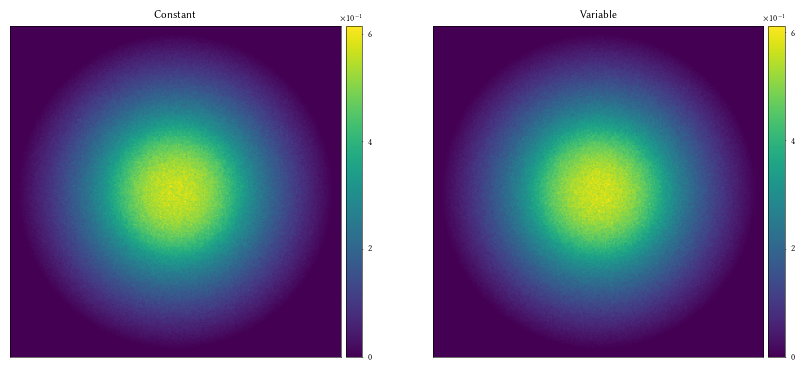

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plot_image(image_c[0], ax1)
plot_image(image_v[0], ax2)
ax1.set_title("Constant")
ax2.set_title("Variable")

Mean:
-1.1799351e-05
Variance:
0.00015164354


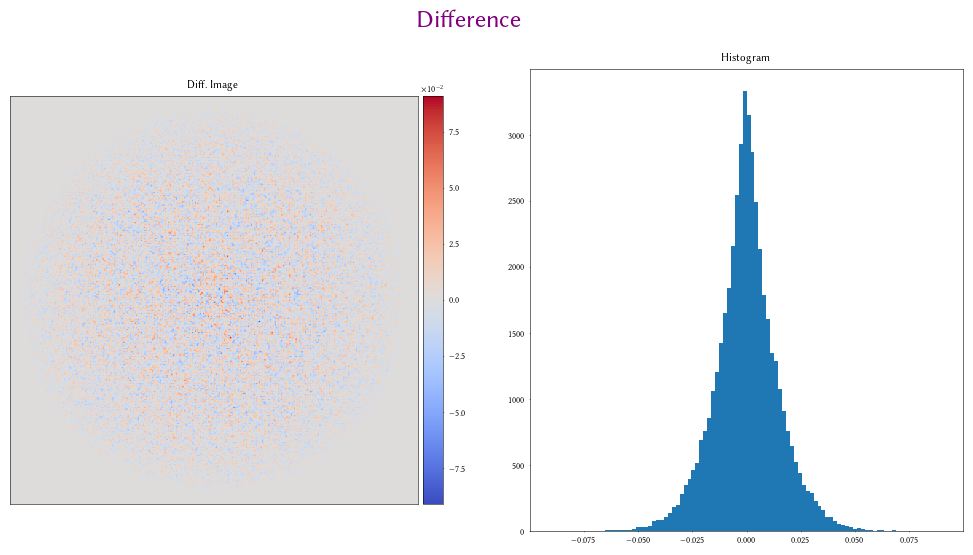

In [8]:
sketch_diff(image_v[0], image_c[0], max_range = 0.2)

In [9]:
rad_der = 0.3
res = 64
spp_der = 2 ** 18
fd_step = 5e-3
points = create_circle_points(radius = rad_der, resolution = res, spp = spp_der)
derivative_dir = points / dr.norm(points)
derivative_dir2 =Point2f(-derivative_dir[1], derivative_dir[0])

In [10]:
derL_v, _ = wos_v.solve(points_in = points, derivative_dir = derivative_dir)
der_v, _ = create_circle_from_result(derL_v, res)

0 : 16777216 -> 0


In [11]:
derL_c, _ = wos_c.solve(points_in = points, derivative_dir = derivative_dir)
der_c, _ = create_circle_from_result(derL_c, res)

Text(0.5, 1.0, 'Radial Derivative Comparison')

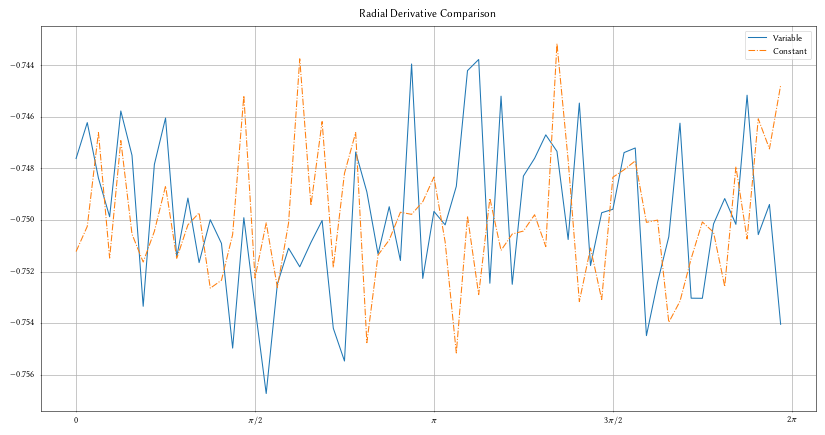

In [12]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
angle = dr.arange(Float, res).numpy() / res * 2 * dr.pi
ax.plot(angle, der_v[0], label = "Variable")
ax.plot(angle, der_c[0], label = "Constant", ls = '-.')
ax.legend()
_ = ax.set_xticks([0, dr.pi/2, dr.pi, 3 * dr.pi / 2, 2 * dr.pi])
_ = ax.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax.grid()
ax.set_title("Radial Derivative Comparison")